# Алексей Сек БЭК182
------

# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

## Часть 1. Обучение моделей классификации (5 баллов). 

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

A. Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

C. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

D. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

E. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC? 
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Импортируем нужные библиотеки

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures

## Часть 1: импорт и обработка данных

In [74]:
# Испортируем данные
df = pd.read_csv("telecom_churn.csv")
df.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [75]:
# Поделим данные на X, y

X = df.iloc[:,:-1]
# Нужно перевести текстовые данные Churn в бинарную переменную
y = df.iloc[:,-1].astype(int)

# Нужно перевести текстовые данные International plan и Voice mail plan в бинарные переменные
X['International plan'] = X['International plan'] == "Yes"
X['International plan'] = X['International plan'].astype(int)

X['Voice mail plan'] = X['Voice mail plan'] == "Yes"
X['Voice mail plan'] = X['Voice mail plan'].astype(int)

# Нужно перевести текстовые данные State в категориальные переменную
labelencoder = LabelEncoder()
X['State'] = labelencoder.fit_transform(X['State'])

X.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [76]:
X.columns.values

array(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls'],
      dtype=object)

In [77]:
# Масштабирование числовых признаков

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

need_to_tranform = ['Account length','Number vmail messages','Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls']

for col in need_to_tranform:
    X[col] = scaler.fit_transform(X[col].values.reshape(-1,1))

X

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,16,0.676489,415,0,1,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,-0.427932
1,35,0.149065,415,0,1,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,-0.427932
2,31,0.902529,415,0,0,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,-1.188218
3,35,-0.428590,408,1,0,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0.332354
4,36,-0.654629,415,1,0,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,1.092641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,2.283878,415,0,1,2.038605,-0.432895,-1.167924,-0.433386,0.286348,1.299506,0.286880,1.547039,-0.874374,1.547188,-0.120832,0.617898,-0.125496,0.332354
3329,49,-0.830437,415,0,0,-0.591760,0.942447,-2.164631,0.942714,-0.938353,-2.264816,-0.938172,-0.189297,1.170023,-0.188670,-0.228304,-0.194831,-0.231645,1.092641
3330,39,-1.835055,510,0,0,-0.591760,0.018820,0.426808,0.019193,1.731930,-2.114211,1.732349,-0.177431,-0.465494,-0.175486,1.383778,0.617898,1.387123,0.332354
3331,6,2.082955,510,1,0,-0.591760,0.624778,0.227466,0.625153,-0.816080,-0.808966,-0.815203,-1.219628,1.885562,-1.221396,-1.876211,2.243356,-1.876950,0.332354


In [2]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1308)

NameError: name 'train_test_split' is not defined

## Часть 1A: Логичестическая регрессия

In [79]:
# A) Логистическая регрессия с поиском гиперпараметров по кросс-валидации
import warnings
warnings.filterwarnings('ignore')

# Используем кроссвалидацию для нахождения оптимального гиперпараметра на тренировочных данных
model = LogisticRegression(solver='lbfgs', multi_class='auto')
params = {'C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(model, params)
grid.fit(Xtrain, ytrain)
grid.best_params_

{'C': 0.5}

In [80]:
# Подставим оптимальный гиперпараметр в модель и обучим ее на тренировочных данных
model = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.5)
model.fit(Xtrain, ytrain)

# Сделаем предсказание на тестовых значения предикторов
ypredtrain = model.predict(Xtrain)
ypred = model.predict(Xtest)

In [81]:
# Посчитаем метрики качества для тренировочных и тестовых данных
# Таким образом поймем, переобучена ли модель или нет
print("accuracy train_set:", accuracy_score(ytrain, ypredtrain))
print("accuracy test_set:", accuracy_score(ytest, ypred))
print("------------------------")

print("precision train_set:", precision_score(ytrain, ypredtrain))
print("precision test_set:", precision_score(ytest, ypred))
print("------------------------")

print("recall train_set:", recall_score(ytrain, ypredtrain))
print("recall test_set:", recall_score(ytest, ypred))
print("------------------------")

print("f1 train_set:", f1_score(ytrain, ypredtrain))
print("f1 test_set:", f1_score(ytest, ypred))
print("------------------------")

print("roc_auc train_set:", roc_auc_score(ytrain, ypredtrain))
print("roc_auc test_set:", roc_auc_score(ytest, ypred))

accuracy train_set: 0.8615903975993998
accuracy test_set: 0.8680659670164917
------------------------
precision train_set: 0.5833333333333334
precision test_set: 0.5
------------------------
recall train_set: 0.23037974683544304
recall test_set: 0.17045454545454544
------------------------
f1 train_set: 0.33030852994555354
f1 test_set: 0.2542372881355932
------------------------
roc_auc train_set: 0.6008789971517593
roc_auc test_set: 0.572273904851625


### Логистическая регрессия - выводы:
Как можно заметить по метрикам, представленным выше, результаты на тестовых данных совсем немного уступают результатам на тренировочных данных. Таким образом, можно заключить, что переобучение есть, но оно не очень существенное

Примечательно, что метрика precision сильно выше на обеих выборках, чем recall.
В целом, качество модели я доволен, так как 86% верных результатов кажется мне вполне хорошим показателем для бинарной классификации

## Часть 1B: SVM

In [82]:
# B) SVM
from sklearn.svm import SVC

# Обучим модель на тренировочных данных
svm = SVC(kernel='linear') 
params = {'C': np.arange(0.1,2,0.1)}
grid = GridSearchCV(svm, params)
grid.fit(Xtrain, ytrain)
grid.best_params_

{'C': 1.9000000000000001}

In [83]:
svm = SVC(kernel='linear', C=1.9)
svm.fit(Xtrain, ytrain)

# Сделаем предсказания
ypredtrain = svm.predict(Xtrain)
ypred = svm.predict(Xtest)

In [84]:
# Посчитаем метрики качества для тренировочных и тестовых данных
# Таким образом поймем, переобучена ли модель или нет
print("accuracy train_set:", accuracy_score(ytrain, ypredtrain))
print("accuracy test_set:", accuracy_score(ytest, ypred))
print("------------------------")

print("precision train_set:", precision_score(ytrain, ypredtrain))
print("precision test_set:", precision_score(ytest, ypred))
print("------------------------")

print("recall train_set:", recall_score(ytrain, ypredtrain))
print("recall test_set:", recall_score(ytest, ypred))
print("------------------------")

print("f1 train_set:", f1_score(ytrain, ypredtrain))
print("f1 test_set:", f1_score(ytest, ypred))
print("------------------------")

print("roc_auc train_set:", roc_auc_score(ytrain, ypredtrain))
print("roc_auc test_set:", roc_auc_score(ytest, ypred))

accuracy train_set: 0.859714928732183
accuracy test_set: 0.8740629685157422
------------------------
precision train_set: 0.8387096774193549
precision test_set: 0.8333333333333334
------------------------
recall train_set: 0.06582278481012659
recall test_set: 0.056818181818181816
------------------------
f1 train_set: 0.12206572769953052
f1 test_set: 0.10638297872340426
------------------------
roc_auc train_set: 0.53181055576922
roc_auc test_set: 0.5275455330507144


### Метод опорных векторов - выводы:

В этом случае только accuracy для тренировочных данных ниже, чем для тестовых. Все остальные метрики ниже для тренировочных данных Предположу, что в этом случае модель немного переобучилась.

Примечательно, что метрика precision сильно выше на обеих выборках, чем recall, как и в логистической регрессии.
В целом, качество модели я доволен, так как 87% верных результатов на тесте кажется мне вполне хорошим показателем для бинарной классификации.

## Часть 1C: Полиномиальные признаки
## Часть 1D: Удаление коррелируемых признаков

### Сделаем две части вместе: сначала удалим мультиколлинеарность, потом добавим полиномиальные признаки

In [86]:
# Построим матрицу корреляций
corr = X.corr()
corr.style.background_gradient(cmap='YlGnBu')

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
State,1.000000,0.003678,0.015814,-0.004597,-0.031664,-0.027762,-0.006737,-0.000764,-0.006736,0.013682,-0.016268,0.013674,0.024576,0.007458,0.024572,-0.007834,0.013967,-0.007819,-0.025861
Account length,0.003678,1.000000,-0.012463,0.024735,0.002918,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
Area code,0.015814,-0.012463,1.000000,0.048551,-0.000747,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572
International plan,-0.004597,0.024735,0.048551,1.000000,0.006006,0.008745,0.049396,0.003755,0.049398,0.019100,0.006114,0.019106,-0.028905,0.012451,-0.028913,0.045871,0.017366,0.045780,-0.024522
Voice mail plan,-0.031664,0.002918,-0.000747,0.006006,1.000000,0.956927,-0.001684,-0.011086,-0.001686,0.021545,-0.006444,0.021559,0.006079,0.015553,0.006064,-0.001318,0.007618,-0.001276,-0.017824
Number vmail messages,-0.027762,-0.004628,-0.001994,0.008745,0.956927,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Total day minutes,-0.006737,0.006216,-0.008264,0.049396,-0.001684,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Total day calls,-0.000764,0.038470,-0.009646,0.003755,-0.011086,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Total day charge,-0.006736,0.006214,-0.008264,0.049398,-0.001686,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Total eve minutes,0.013682,-0.006757,0.003580,0.019100,0.021545,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985


#### Пять пар предикторов показали корреляцию, близкую к единице. Их связь очевидна, даже исходя из здравого смысла
1. Number vmail messages and Voice mail plan
2. Total day charge and Total day minutes
3. Total eve charge and Total eve minutes
4. Total night charge and Total night minutes
5. Total intl charge and Total intl minutes

Давайте удалим по одному из каждой пары

In [87]:
X = X[['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Total day minutes',
       'Total day calls', 'Total eve minutes',
       'Total eve calls', 'Total night minutes',
       'Total night calls', 'Total intl minutes',
       'Total intl calls', 'Customer service calls']]

#### Добавим полиномиальные переменные

In [88]:
# Если честно, я не очень понял, зачем использовать функцию, которая выдает по сути 3 столбца (единицы, сами значения и их квадраты)
# Но, видимо, это предполагалось заданием, поэтому я немного извратил код и все же использовал PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

poly_vars = ['Total day minutes',
       'Total day calls', 'Total eve minutes',
       'Total eve calls', 'Total night minutes',
       'Total night calls', 'Total intl minutes',
       'Total intl calls', 'Customer service calls']

poly = PolynomialFeatures(degree=2)

for var in poly_vars:
    p = pd.DataFrame(poly.fit_transform(np.array(X[var]).reshape(-1, 1)))
    p = p.iloc[:,-1]
    X[var + '^2'] = p

X.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,...,Customer service calls,Total day minutes^2,Total day calls^2,Total eve minutes^2,Total eve calls^2,Total night minutes^2,Total night calls^2,Total intl minutes^2,Total intl calls^2,Customer service calls^2
0,16,0.676489,415,0,1,1.566767,0.476643,-0.070610,-0.055940,0.866743,...,-0.427932,2.454759,0.227189,0.004986,0.003129,0.751244,0.216685,0.007226,0.361436,0.183126
1,35,0.149065,415,0,1,-0.333738,1.124503,-0.108080,0.144867,1.058571,...,-0.427932,0.111381,1.264507,0.011681,0.020986,1.120572,0.021852,1.538795,0.361436,0.183126
2,31,0.902529,415,0,0,1.168304,0.675985,-1.573383,0.496279,-0.756869,...,-1.188218,1.364933,0.456955,2.475535,0.246292,0.572851,0.039575,0.494379,0.044747,1.411863
3,35,-0.428590,408,1,0,2.196596,-1.466936,-2.742865,-0.608159,-0.078551,...,0.332354,4.825034,2.151901,7.523307,0.369858,0.006170,0.322299,1.697877,1.049114,0.110459
4,36,-0.654629,415,1,0,-0.240090,0.626149,-1.038932,1.098699,-0.276311,...,1.092641,0.057643,0.392063,1.079380,1.207140,0.076348,1.140204,0.002419,0.361436,1.193864


In [89]:
# Не забудем заново поделить на train и test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1308)

#### Повторим код для логистической регрессии на данных с полиномиальными признаками

In [90]:
import warnings
warnings.filterwarnings('ignore')

# Используем кроссвалидацию для нахождения оптимального гиперпараметра на тренировочных данных
model = LogisticRegression(solver='lbfgs', multi_class='auto')
params = {'C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(model, params)
grid.fit(Xtrain, ytrain)
grid.best_params_

{'C': 0.7000000000000001}

In [91]:
# Подставим оптимальный гиперпараметр в модель и обучим ее на тренировочных данных
model = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.7)
model.fit(Xtrain, ytrain)

# Сделаем предсказание на тестовых значения предикторов
ypredtrain = model.predict(Xtrain)
ypred = model.predict(Xtest)

In [92]:
# Посчитаем метрики качества для тренировочных и тестовых данных
# Таким образом поймем, переобучена ли модель или нет
print("accuracy train_set:", accuracy_score(ytrain, ypredtrain))
print("accuracy test_set:", accuracy_score(ytest, ypred))
print("------------------------")

print("precision train_set:", precision_score(ytrain, ypredtrain))
print("precision test_set:", precision_score(ytest, ypred))
print("------------------------")

print("recall train_set:", recall_score(ytrain, ypredtrain))
print("recall test_set:", recall_score(ytest, ypred))
print("------------------------")

print("f1 train_set:", f1_score(ytrain, ypredtrain))
print("f1 test_set:", f1_score(ytest, ypred))
print("------------------------")

print("roc_auc train_set:", roc_auc_score(ytrain, ypredtrain))
print("roc_auc test_set:", roc_auc_score(ytest, ypred))

accuracy train_set: 0.881470367591898
accuracy test_set: 0.8860569715142429
------------------------
precision train_set: 0.6926829268292682
precision test_set: 0.6428571428571429
------------------------
recall train_set: 0.3594936708860759
recall test_set: 0.3068181818181818
------------------------
f1 train_set: 0.47333333333333333
f1 test_set: 0.41538461538461546
------------------------
roc_auc train_set: 0.6658762938314131
roc_auc test_set: 0.6404557230334432


#### Повторим код для svm на данных с полиномиальными признаками

In [93]:
from sklearn.svm import SVC

# Обучим модель на тренировочных данных
svm = SVC(kernel='linear') 
params = {'C': np.arange(0.1,2,0.1)}
grid = GridSearchCV(svm, params)
grid.fit(Xtrain, ytrain)
grid.best_params_

{'C': 0.30000000000000004}

In [94]:
svm = SVC(kernel='linear', C=0.3)
svm.fit(Xtrain, ytrain)

# Сделаем предсказания
ypredtrain = svm.predict(Xtrain)
ypred = svm.predict(Xtest)

In [95]:
# Посчитаем метрики качества для тренировочных и тестовых данных
# Таким образом поймем, переобучена ли модель или нет
print("accuracy train_set:", accuracy_score(ytrain, ypredtrain))
print("accuracy test_set:", accuracy_score(ytest, ypred))
print("------------------------")

print("precision train_set:", precision_score(ytrain, ypredtrain))
print("precision test_set:", precision_score(ytest, ypred))
print("------------------------")

print("recall train_set:", recall_score(ytrain, ypredtrain))
print("recall test_set:", recall_score(ytest, ypred))
print("------------------------")

print("f1 train_set:", f1_score(ytrain, ypredtrain))
print("f1 test_set:", f1_score(ytest, ypred))
print("------------------------")

print("roc_auc train_set:", roc_auc_score(ytrain, ypredtrain))
print("roc_auc test_set:", roc_auc_score(ytest, ypred))

accuracy train_set: 0.8743435858964741
accuracy test_set: 0.8950524737631185
------------------------
precision train_set: 0.6829268292682927
precision test_set: 0.7647058823529411
------------------------
recall train_set: 0.28354430379746837
recall test_set: 0.29545454545454547
------------------------
f1 train_set: 0.4007155635062612
f1 test_set: 0.42622950819672134
------------------------
roc_auc train_set: 0.6303234508859644
roc_auc test_set: 0.6408188098602606


### Добавление полиномиальных признаков и удаление мультиколлинеарности - выводы:

- Логистическая регрессия: accuracy практически не изменился, precision, recall, f1, roc_auc повысились и на train, и на test. Поэтому в целом качество модели улучшилось. Тем не менее все равно все метрики на тренировочных данных выше, чем на тестовых -> переобучение избежать мы не смогли.

- SVM: accuracy практически не изменился, precision, recall, f1, roc_auc повысились и на train, и на test. В целом качество модели улучшилось. На тестовых данных все метрики даже выше, чем на тренировочных, поэтому с переобучением мы справились

## Часть 1E: Мини Отчет

#### a)  После удаления коррелированных переменных и добавления полиномиальных признаков лучшей себя показала модель SVM по всем 3 метрикам: Accuracy, F1, ROC-AUC

Я разбивал данные на train и test и потом считал метрики на каждой из них

#### До удаления коррелированных переменных и добавления полиномиальных признаков:

##### LogReg:
- accuracy train_set: 0.8615903975993998
- accuracy test_set: 0.8680659670164917
- - 
- f1 train_set: 0.33030852994555354
- f1 test_set: 0.2542372881355932
- -
- roc_auc train_set: 0.6008789971517593
- roc_auc test_set: 0.572273904851625


##### SVM:
- accuracy train_set: 0.859714928732183
- accuracy test_set: 0.8740629685157422
- -
- f1 train_set: 0.12206572769953052
- f1 test_set: 0.10638297872340426
- -
- roc_auc train_set: 0.53181055576922
- roc_auc test_set: 0.5275455330507144


##### После удаления коррелированных переменных и добавления полиномиальных признаков:

##### LogReg:
- accuracy train_set: 0.881470367591898
- accuracy test_set: 0.8860569715142429
- -
- f1 train_set: 0.47333333333333333
- f1 test_set: 0.41538461538461546
- -
- roc_auc train_set: 0.6658762938314131
- roc_auc test_set: 0.6404557230334432


##### SVM:
- accuracy train_set: 0.8743435858964741
- accuracy test_set: 0.8950524737631185
- 
- f1 train_set: 0.4007155635062612
- f1 test_set: 0.42622950819672134
- -
- roc_auc train_set: 0.6303234508859644
- roc_auc test_set: 0.6408188098602606




#### b) Добавил квадраты следующих признаков:
- 'Total day minutes'
- 'Total day calls'
- 'Total eve minutes'
- 'Total eve calls'
- 'Total night minutes'
- 'Total night calls'
- 'Total intl minutes'
- 'Total intl calls'
- 'Customer service calls'

##### Удалил следующие признаки:
- Number vmail messages
- Total day charge
- Total eve charge
- Total night charge
- Total intl charge

#### c) Для SVM существенного переобучения не было заметно и сначала. Для Логистической регрессии переобучение как было, так и осталась. На самом деле добавление полиномиальных переменных должно только увеличить переобучение, хотя удаление лишних переменных может как-то поправить ситуацию

## Часть 2. Оценка качества моделей классификации (5 баллов).

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные). 
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [178]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [179]:
df.shape

(689, 21)

**Задание 1.** Проверьте target на сбалансированность по классам, сделайте вывод.

In [98]:
# Посмотрим, сколько в каждом классе наблюдений

df_classes = pd.DataFrame(df.groupby(by='target').target.count())
df_classes.columns.values[0] = 'value'
df_classes

,value
target,
0,382
1,307


**Вывод:** наблюдается дисбаланс классов по таргету - нулей существенно больше, чем единиц

**Задание 2.** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [102]:
# Просто, чтобы скопировать названия столбцов
df.columns.values

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', 'target', 'pred1_probs', 'pred1_classes', 'pred2_probs',
       'pred2_classes', 'pred3_probs', 'pred3_classes'], dtype=object)

In [103]:
# Выведем accuracy каждой модели
print('Model_1:',accuracy_score(df.target, df.pred1_classes))
print('Model_2:',accuracy_score(df.target, df.pred2_classes))
print('Model_3:',accuracy_score(df.target, df.pred3_classes))

Model_1: 0.6618287373004355
Model_2: 0.6719883889695211
Model_3: 0.6400580551523948


**Выводы:** наилучший показатель accuracy у модели 2

**Задание 3.** Теперь вычислите точность и полноту каждого из алгоритмов.

In [192]:
# Выведем precision каждой модели
print('PRECISION:')
print('Model_1:',precision_score(df.target, df.pred1_classes))
print('Model_2:',precision_score(df.target, df.pred2_classes))
print('Model_3:',precision_score(df.target, df.pred3_classes))#your code here

PRECISION:
Model_1: 0.6907216494845361
Model_2: 0.6103542234332425
Model_3: 0.6903225806451613


In [190]:
# Выведем recall каждой модели
print('RECALL:')
print('Model_1:',recall_score(df.target, df.pred1_classes))
print('Model_2:',recall_score(df.target, df.pred2_classes))
print('Model_3:',recall_score(df.target, df.pred3_classes))#your code here

RECALL:
Model_1: 0.4364820846905538
Model_2: 0.7296416938110749
Model_3: 0.3485342019543974


**Выводы:** наилучший показатель precision (точность) у модели 1, наилучший показатель recall (полнота) у модели 2

**Задание 4.** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

In [106]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

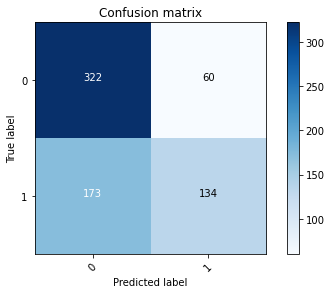

In [109]:
# Матрица ошибок первого алгоритма
cm = confusion_matrix(df.target, df.pred1_classes)
classes = [0,1]
plot_confusion_matrix(cm, classes)

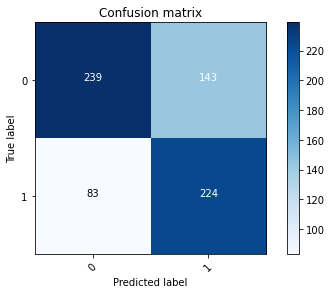

In [110]:
# Матрица ошибок второго алгоритма
cm = confusion_matrix(df.target, df.pred2_classes)
classes = [0,1]
plot_confusion_matrix(cm, classes)

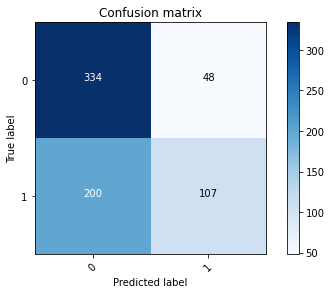

In [111]:
# Матрица ошибок третьего алгоритма
cm = confusion_matrix(df.target, df.pred3_classes)
classes = [0,1]
plot_confusion_matrix(cm, classes)

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5.** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [187]:
# Создадим отдельный датафрейм для первой модели
check = pd.DataFrame(df.target)
check['pred1_probs'] = df.pred1_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
recalls = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred1_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    recall_temp = recall_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    recalls.append(recall_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, recalls],index=['threshold', 'accuracy', 'recall'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 65%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.65]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 1:', results.index[results.recall.argmax()])
    print('Максимальная полнота (recall) для алгоритма 1:', results.recall.iloc[results.recall.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.65')

Пороговое значения для алгоритма 1: 0.36000000000000004
Максимальная полнота (recall) для алгоритма 1: 0.742671009771987


In [188]:
# Создадим отдельный датафрейм для второй модели
check = pd.DataFrame(df.target)
check['pred2_probs'] = df.pred2_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
recalls = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred2_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    recall_temp = recall_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    recalls.append(recall_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, recalls],index=['threshold', 'accuracy', 'recall'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 65%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.65]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 2:', results.index[results.recall.argmax()])
    print('Максимальная полнота (recall) для алгоритма 2:', results.recall.iloc[results.recall.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.65')

Пороговое значения для алгоритма 2: 0.27
Максимальная полнота (recall) для алгоритма 2: 0.8371335504885994


In [195]:
# Создадим отдельный датафрейм для третьей модели
check = pd.DataFrame(df.target)
check['pred3_probs'] = df.pred3_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
recalls = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred3_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    recall_temp = recall_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    recalls.append(recall_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, recalls],index=['threshold', 'accuracy', 'recall'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 65%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.65]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 3:', results.index[results.recall.argmax()])
    print('Максимальная полнота (recall) для алгоритма 3:', results.recall.iloc[results.recall.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.65')

Нет пороговых значений с accuracy выше 0.65


**На самом деле там есть значения accuracy выше 64%, давайте будем брать их для задачи 6 для третьей модели**

In [196]:
# Создадим отдельный датафрейм для третьей модели
check = pd.DataFrame(df.target)
check['pred3_probs'] = df.pred3_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
recalls = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred3_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    recall_temp = recall_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    recalls.append(recall_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, recalls],index=['threshold', 'accuracy', 'recall'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 65%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.64]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 3:', results.index[results.recall.argmax()])
    print('Максимальная полнота (recall) для алгоритма 3:', results.recall.iloc[results.recall.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.65')

Пороговое значения для алгоритма 3: 0.23
Максимальная полнота (recall) для алгоритма 3: 0.6416938110749185


**Задание 6.** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

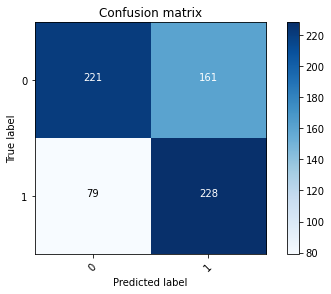

In [197]:
# Построим прогноз первого алгоритма с выбранным порогом
pred1_new = df.pred1_probs >= 0.36
pred1_new = pred1_new.astype(int)

# Матрица ошибок первого алгоритма
cm = confusion_matrix(df.target, pred1_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в левом нижнем углу уменьшилось

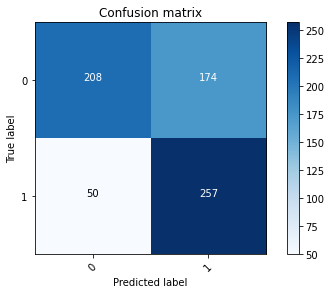

In [198]:
# Построим прогноз второго алгоритма с выбранным порогом
pred2_new = df.pred2_probs >= 0.27
pred2_new = pred2_new.astype(int)

# Матрица ошибок второго алгоритма
cm = confusion_matrix(df.target, pred2_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в левом нижнем углу уменьшилось

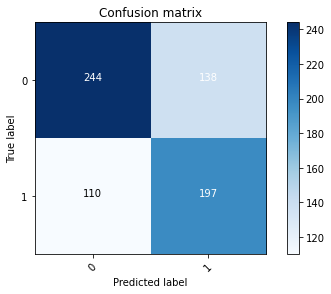

In [199]:
# Построим прогноз третьего алгоритма с выбранным порогом
pred3_new = df.pred3_probs >= 0.23
pred3_new = pred3_new.astype(int)

# Матрица ошибок третьего алгоритма
cm = confusion_matrix(df.target, pred3_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в левом нижнем углу уменьшилось

**Выводы:** Модель 2 лучше всего справилась с поставленной задачей, потому что в ней наименьшее число ошибок в левом нижнем квадрате, что мы и хотели получить (максимальный recall)

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги). 
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7.** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65? 

In [202]:
# Создадим отдельный датафрейм для первой модели
check = pd.DataFrame(df.target)
check['pred1_probs'] = df.pred1_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
precisions = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred1_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    precision_temp = precision_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    precisions.append(precision_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, precisions],index=['threshold', 'accuracy', 'precision'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 65%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.65]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 1:', results.index[results.precision.argmax()])
    print('Максимальная точность (precision) для алгоритма 1:', results.precision.iloc[results.precision.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.65')

Пороговое значения для алгоритма 1: 0.54
Максимальная точность (precision) для алгоритма 1: 0.7371794871794872


In [203]:
# Создадим отдельный датафрейм для второй модели
check = pd.DataFrame(df.target)
check['pred2_probs'] = df.pred2_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
precisions = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred2_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    precision_temp = precision_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    precisions.append(precision_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, precisions],index=['threshold', 'accuracy', 'precision'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 65%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.65]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 2:', results.index[results.precision.argmax()])
    print('Максимальная точность (precision) для алгоритма 2:', results.precision.iloc[results.precision.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.65')

Пороговое значения для алгоритма 2: 0.73
Максимальная точность (precision) для алгоритма 2: 0.8367346938775511


**Нет пороговых значений с accuracy >= 65%, поэтому возьмем 64% для третьей модели** 

In [244]:
# Создадим отдельный датафрейм для третьей модели
check = pd.DataFrame(df.target)
check['pred3_probs'] = df.pred3_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
precisions = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred3_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    precision_temp = precision_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    precisions.append(precision_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, precisions],index=['threshold', 'accuracy', 'precision'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 64%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.64]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 3:', results.index[results.precision.argmax()])
    print('Максимальная точность (precision) для алгоритма 3:', results.precision.iloc[results.precision.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.64')

Пороговое значения для алгоритма 3: 0.56
Максимальная точность (precision) для алгоритма 3: 0.7142857142857143


**Задание 8.** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

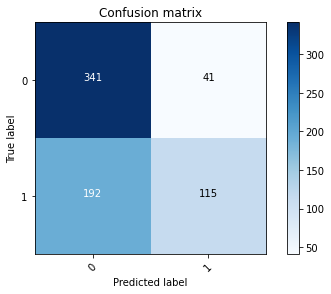

In [206]:
# Построим прогноз первого алгоритма с выбранным порогом
pred1_new = df.pred1_probs >= 0.54
pred1_new = pred1_new.astype(int)

# Матрица ошибок первого алгоритма
cm = confusion_matrix(df.target, pred1_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в правом верхнем углу уменьшилось

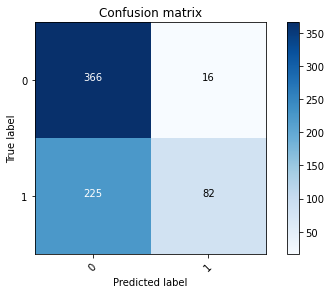

In [207]:
# Построим прогноз второго алгоритма с выбранным порогом
pred2_new = df.pred2_probs >= 0.73
pred2_new = pred2_new.astype(int)

# Матрица ошибок второго алгоритма
cm = confusion_matrix(df.target, pred2_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в правом верхнем углу уменьшилось

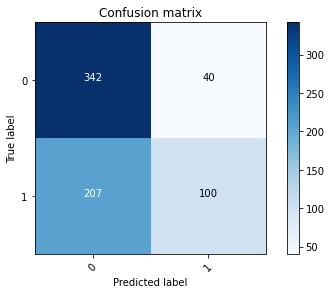

In [208]:
# Построим прогноз третьего алгоритма с выбранным порогом
pred3_new = df.pred3_probs >= 0.56
pred3_new = pred3_new.astype(int)

# Матрица ошибок третьего алгоритма
cm = confusion_matrix(df.target, pred3_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в правом верхнем углу уменьшилось

**Выводы:** Модель 2 лучше всего справилась с поставленной задачей, потому что в ней наименьшее число ошибок в верхнем правом квадрате, что мы и хотели получить (максимальный precision)

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9.** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

**Здесь мы не будем ограничивать accuracy, будем максимизировать только F1-score**

In [210]:
# Создадим отдельный датафрейм для первой модели
check = pd.DataFrame(df.target)
check['pred1_probs'] = df.pred1_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
f1s = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred1_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    f1_temp = f1_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    f1s.append(f1_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, f1s],index=['threshold', 'accuracy', 'f1'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T


# Выведем результаты
print('Пороговое значения для алгоритма 1:', results.index[results.f1.argmax()])
print('Максимальный f1 для алгоритма 1:', results.f1.iloc[results.f1.argmax()])

Пороговое значения для алгоритма 1: 0.34
Максимальный f1 для алгоритма 1: 0.672


In [211]:
# Создадим отдельный датафрейм для второй модели
check = pd.DataFrame(df.target)
check['pred2_probs'] = df.pred2_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
f1s = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred2_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    f1_temp = f1_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    f1s.append(f1_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, f1s],index=['threshold', 'accuracy', 'f1'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T


# Выведем результаты
print('Пороговое значения для алгоритма 2:', results.index[results.f1.argmax()])
print('Максимальный f1 для алгоритма 2:', results.f1.iloc[results.f1.argmax()])

Пороговое значения для алгоритма 2: 0.32
Максимальный f1 для алгоритма 2: 0.6990291262135923


In [212]:
# Создадим отдельный датафрейм для третьей модели
check = pd.DataFrame(df.target)
check['pred3_probs'] = df.pred3_probs

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
f1s = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred3_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    f1_temp = f1_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    f1s.append(f1_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, f1s],index=['threshold', 'accuracy', 'f1'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T


# Выведем результаты

print('Пороговое значения для алгоритма 3:', results.index[results.f1.argmax()])
print('Максимальный f1 для алгоритма 3:', results.f1.iloc[results.f1.argmax()])


Пороговое значения для алгоритма 3: 0.15000000000000002
Максимальный f1 для алгоритма 3: 0.6443418013856813


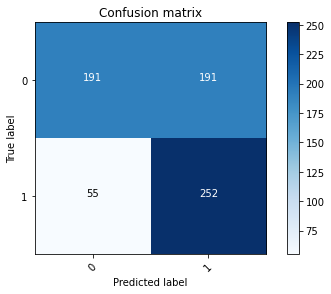

In [213]:
# Построим прогноз первого алгоритма с выбранным порогом
pred1_new = df.pred1_probs >= 0.34
pred1_new = pred1_new.astype(int)

# Матрица ошибок первого алгоритма
cm = confusion_matrix(df.target, pred1_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в правом верхнем углу уменьшилось

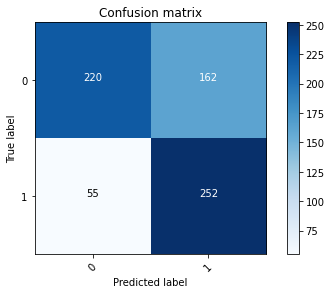

In [214]:
# Построим прогноз второго алгоритма с выбранным порогом
pred2_new = df.pred2_probs >= 0.32
pred2_new = pred2_new.astype(int)

# Матрица ошибок второго алгоритма
cm = confusion_matrix(df.target, pred2_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в правом верхнем углу уменьшилось

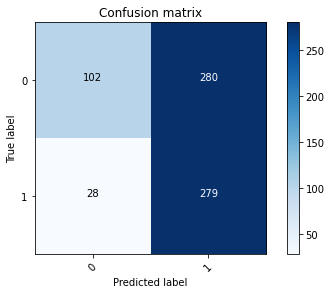

In [215]:
# Построим прогноз третьего алгоритма с выбранным порогом
pred3_new = df.pred3_probs >= 0.15
pred3_new = pred3_new.astype(int)

# Матрица ошибок третьего алгоритма
cm = confusion_matrix(df.target, pred3_new)
classes = [0,1]
plot_confusion_matrix(cm, classes)

# Действительно число в правом верхнем углу уменьшилось

**Выводы:** Модель 2 лучше всего справилась с поставленной задачей, потому что в ней наибольший F1-score

#### Общие выводы из анализа 3 представленных моделей:
- Модель 2 показала себя наилучшей по всем метрикам (recall, precision, F1-score) при выборе оптимального порого при заданных условиях на accuracy

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [209]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       382
           1       0.69      0.44      0.53       307

    accuracy                           0.66       689
   macro avg       0.67      0.64      0.63       689
weighted avg       0.67      0.66      0.65       689



### Обучим свою модель для предсказания target.

**Задание 10.** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [217]:
# Чтобы скопирвоать нужные столбцы и не ошибиться с именами столбцов
df.columns.values

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', 'target', 'pred1_probs', 'pred1_classes', 'pred2_probs',
       'pred2_classes', 'pred3_probs', 'pred3_classes'], dtype=object)

In [219]:
# То же самое, что я делал в части 1 - стандиртизируем признаки

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

need_to_tranform = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

for col in need_to_tranform:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,0.689474,-0.800189,1.345702,0.543460,-0.915390,-0.348248,-0.190685,-1.049099,-0.865292,-0.494332,...,0.238010,-0.487079,0.037071,0,0.506772,1,0.610853,1,0.375494,0
1,-1.450381,-0.750225,0.449679,0.543460,0.170626,-0.348248,-0.615008,-1.049099,-0.865292,-0.494332,...,0.238010,-0.138406,-0.195561,0,0.358519,0,0.185941,0,0.200975,0
2,-1.450381,-0.165051,-0.605056,-1.782279,-0.915390,-0.348248,-0.290789,-1.049099,-0.865292,-0.494332,...,0.238010,0.558939,-0.195561,0,0.358753,0,0.523009,1,0.160465,0
3,-1.450381,-0.834910,1.353739,-1.782279,-0.643886,-0.850220,-0.664313,0.953198,1.155679,1.768074,...,0.238010,-1.068200,-0.195561,1,0.408729,0,0.185941,0,0.357771,0
4,0.689474,-0.961938,0.684735,0.543460,-0.372382,-0.348248,-0.078628,0.953198,1.155679,2.385094,...,0.238010,-0.719527,-0.165234,1,0.480904,0,0.526646,1,0.260169,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.689474,0.003472,1.152837,0.543460,1.799650,-0.348248,1.278011,0.953198,-0.865292,-0.494332,...,0.238010,-1.068200,-0.195561,1,0.776376,1,0.804659,1,0.910302,1
685,0.689474,-0.919595,-0.873260,0.543460,0.170626,-0.348248,-0.626961,-1.049099,-0.865292,-0.494332,...,0.238010,-1.068200,-0.187115,0,0.273138,0,0.175782,0,0.139252,0
686,-1.450381,-1.075416,0.959971,0.543460,-0.372382,-0.348248,-0.638914,0.953198,-0.865292,-0.494332,...,0.238010,-0.487079,-0.195561,1,0.383878,0,0.185941,0,0.272625,0
687,-1.450381,-0.347971,1.956445,0.543460,1.799650,1.659642,0.257544,0.953198,1.155679,-0.288659,...,0.238010,-0.370855,-0.193449,1,0.645865,1,0.804659,1,0.682064,1


In [220]:
# Вытащим X и y из общего датафрейма
X = df[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']]
y = df['target']

In [221]:
# Не забудем заново поделить на train и test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1308)

In [222]:
# Логистическая регрессия с поиском гиперпараметров по кросс-валидации
import warnings
warnings.filterwarnings('ignore')

# Используем кроссвалидацию для нахождения оптимального гиперпараметра на тренировочных данных
model = LogisticRegression(solver='lbfgs', multi_class='auto')
params = {'C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(model, params)
grid.fit(Xtrain, ytrain)
grid.best_params_

{'C': 0.1}

In [224]:
# Подставим оптимальный гиперпараметр в модель и обучим ее на тренировочных данных
model = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.1)
model.fit(Xtrain, ytrain)

# Сделаем предсказание на тестовых значения предикторов
ypredtrain = model.predict(Xtrain)
ypred = model.predict(Xtest)
ypred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0])

In [232]:
# Нам важны не столько сами классы, как их вероятности (чтобы потом посчитать пороги)
probabilities = model.predict_proba(Xtest)
probabilities = pd.DataFrame(probabilities)
probabilities = probabilities.iloc[:,1]
probabilities = pd.DataFrame(probabilities)
probabilities

,1
0,0.160992
1,0.771997
2,0.290703
3,0.024175
4,0.106317
...,...
133,0.902701
134,0.345172
135,0.162343
136,0.369072


**Задание 11.** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

### Важный момент здесь - это то, что я не до конца понимаю, были ли модели, показанные выше, обучены на всей представленной выборке или тоже брали какой-то train subset, тренировали на нем, а потом предсказывали всю выборку (train + test)

### В своей модели я все-таки поделю на train и test и предсказывать буду только test, т.к. предсказывать train subset, обучав на нем же, мне кажется, не совсем правильным

### Вышесказанное не позволяет в полной мере сравнивать модели выше и мою модель

In [251]:
# PRECISION (точность)

check = pd.DataFrame(ytest)
check['pred1_probs'] = probabilities

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
precisions = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred1_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    precision_temp = precision_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    precisions.append(precision_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, precisions],index=['threshold', 'accuracy', 'precision'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 50%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.50]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 1:', results.index[results.precision.argmax()])
    print('Максимальная точность (precision) для алгоритма 1:', results.precision.iloc[results.precision.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.50')

Пороговое значения для алгоритма 1: 0.78
Максимальная точность (precision) для алгоритма 1: 1.0


In [253]:
# RECALL (полнота)

check = pd.DataFrame(ytest)
check['pred_probs'] = probabilities

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
recalls = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    recall_temp = recall_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    recalls.append(recall_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, recalls],index=['threshold', 'accuracy', 'recall'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T

# Сначала выберем только результаты с accuracy выше 50%, а потом из них найдем максимальный recall
results = results[results.accuracy >= 0.50]


# Выведем результаты
try:
    print('Пороговое значения для алгоритма 1:', results.index[results.recall.argmax()])
    print('Максимальная полнота (recall) для алгоритма 1:', results.recall.iloc[results.recall.argmax()])
except ValueError:
    print('Нет пороговых значений с accuracy выше 0.50')

Пороговое значения для алгоритма 1: 0.01
Максимальная полнота (recall) для алгоритма 1: 0.14754098360655737


In [252]:
# F1-SCORE

check = pd.DataFrame(df.target)
check['pred_probs'] = probabilities

# Будем сохранять значения метрик при каждом пороговом значении
thresholds = []
accuracies = []
f1s = []

# Проитерируемся по всем порогам с шагом 0.01
for i in np.linspace(0.01,0.99,99):
    threshold = i
    
    temp_pred = check.pred_probs >= i
    temp_pred = temp_pred.astype(int)
    
    accuracy_temp = accuracy_score(check.target, temp_pred)
    f1_temp = f1_score(check.target, temp_pred)
    
    thresholds.append(i)
    accuracies.append(accuracy_temp)
    f1s.append(f1_temp)
    
# Сохраним результаты цицкла в удобном формате
results = pd.DataFrame([thresholds, accuracies, f1s],index=['threshold', 'accuracy', 'f1'])
results.columns = results.iloc[0,:]
results = results.iloc[1:,:]
results = results.T


# Выведем результаты
print('Пороговое значения для алгоритма 1:', results.index[results.f1.argmax()])
print('Максимальный f1 для алгоритма 1:', results.f1.iloc[results.f1.argmax()])

Пороговое значения для алгоритма 1: 0.01
Максимальный f1 для алгоритма 1: 0.28828828828828834


**Почему-то у меня не было значений accuracy выше 0,65, поэтому я взял accuracy выше 0.50 и считал, отталкиваясь от этого**

Получилось, что максимальные значения метрик следующие:
- Precision: 1.0
- Recall: 0.14
- F1-score: 0.29

Даже на глаз заметно, что значения метрик (кроме precision) ниже, чем в представленных выше трех моделях. Учитывая то, что здесь не было порогов, при которых accuracy >= 0.65, можем заключить, что в целом логистическая регрессия хуже справилась с задачей